In [1]:
import torch
from torch import nn

In [2]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k
    def forward(self, q, k, v, attention_mask):
        ####Tensor dimension####################
        #### q [batch_size, n_heads, len_q, d_k]
        #### k [batch_size, n_heads, len_k, d_k]
        #### v [batch_size, n_heads, len_v, d_v]
        ####attension_mask [batch_size, n_heads, seq_len, seq_len]
        ####
        ####calculate score q and k
        score = torch.matmul(q, k.transpose(-1, -2))/np.sqrt(self.d_k)
        ####extend the length and fill a small number
        score.masked_fill_(attention_mask, -1e10)
        ####softmax with last dimension
        attn = nn.Softmax(dim=-1)(score)     
        ####After attension [batch_size, n_heads, len_q, d_v]
        context = torch.matmul(attn, v)
        return context, attn
        

In [3]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_k
        self.d_v = d_v
        self.w_q = nn.Linear(d_model, d_k * n_heads, bias = False)
        self.w_k = nn.Linear(d_model, d_k * n_heads, bias = False)
        self.w_v = nn.Linear(d_model, d_v * n_heads, bias = False)
        self.fc = nn.Linear(d_model, d_v * n_heads, bias = False)
        self.layernorm = nn.LayerNorm(d_model)
        
    def forward(self, q, k, v, attention_mask):
        ####Tensor dimension####################
        #### q [batch_size, n_heads, len_q, d_k]
        #### k [batch_size, n_heads, len_k, d_k]
        #### v [batch_size, n_heads, len_v, d_v]
        ####attension_mask [batch_size, n_heads, seq_len, seq_len]
        residual, batch_size = q, q.size(0)
        ####calculate q, k, v####
        q = self.w_q(q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)
        k = self.w_k(k).view(batch_size, -1, self.n_heads, self.d_k).transpose(1,2)
        v = self.w_v(v).view(batch_size, -1, self.n_heads, self.d_v).transpose(1,2)
        ####calculate attention mask####
        attention_mask = attention_mask.unsqueeze(1).repeat(1, self.n_heads, 1, 1)
        ####calculate score####
        context, attn = ScaledDotProductAttention(self.d_k)(q, k, v, attention_mask)
        context = context.transpose(1,2).reshape(batch_size, -1, self.n_heads*self.d_v)
        output = self.fc(context)
        return self.layernorm(output+residual), attn

In [4]:
class PoswiseFeedForwardNet(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.fc = nn.Sequential(
        nn.Linear(d_model, d_ff, bias = False),
        nn.ReLU(),
        nn.Linear(d_ff, d_model, bias = False)
        )
        self.layernorm = nn.LayerNorm(d_model)
    
    def forward(self, inputs):
        ###inputs [batch_size, seq_len, d_model]
        residual = inputs
        output = self.fc(inputs)
        return self.layernorm(output+residual)
    

In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, d_k, d_v):
        super(DecoderLayer, self).__init__()
        # Multi-head attention
        self.attention = MultiHeadAttention(d_model, n_heads, d_k, d_v)
        # feedforward layer
        self.pos_ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
    def forward(self, inputs, attention_mask):
        ##
        # inputs: [batch_size, seq_len, d_model]
        # attention_mask: [batch_size, seq_len, seq_len]
        ##
        # outputs: [batch_size, seq_len, d_model]
        # self_attn: [batch_size, n_heads, seq_len, seq_len]
        outputs, self_attn = self.attention(inputs, inputs, inputs, attention_mask)
        # [batch_size, seq_len, d_model]
        outputs = self.pos_ffn(outputs)
        return outputs, self_attn


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_pos, device):
        super(PositionalEncoding, self).__init__()
        self.device = device
        self.pos_embedding = nn.Embedding(max_pos, d_model)

    def forward(self, inputs):
        seq_len = inputs.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=self.device)
        # [seq_len] -> [batch_size, seq_len]
        pos = pos.unsqueeze(0).expand_as(inputs)
        return self.pos_embedding(pos)

In [7]:
def get_attn_subsequence_mask(seq, device):
    # attention score dimention [batch_size, n_heads, len_seq, len_seq]
    # mask generation [batch_size, len_seq, len_seq]
    attn_shape = [seq.size(0), seq.size(1), seq.size(1)]
    # generate an upper left matrix
    subsequence_mask = np.triu(np.ones(attn_shape), k=1)
    subsequence_mask = torch.from_numpy(subsequence_mask).byte()
    subsequence_mask = subsequence_mask.to(device)
    return subsequence_mask

In [8]:
def get_attn_pad_mask(attention_mask):
    batch_size, len_seq = attention_mask.size()
    attention_mask = attention_mask.data.eq(0).unsqueeze(1)
    return attention_mask.expand(batch_size, len_seq, len_seq)


In [9]:
class Decoder(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, d_k, d_v, vocab_size, max_pos, n_layers, device):
        super(Decoder, self).__init__()
        self.device = device
        # Tokenization
        self.embedding = nn.Embedding(vocab_size, d_model)
        # positional encodinng
        self.pos_encoding = PositionalEncoding(d_model, max_pos, device)
        self.layers = nn.ModuleList([DecoderLayer(d_model, n_heads, d_ff, d_k, d_v) for _ in range(n_layers)])

    def forward(self, inputs, attention_mask):
        ##
        # inputs: [batch_size, seq_len]
        ##
        # [batch_size, seq_len, d_model]
        outputs = self.embedding(inputs) + self.pos_encoding(inputs)
        # 上三角掩码，防止看到未来的信息， [batch_size, seq_len, seq_len]
        subsequence_mask = get_attn_subsequence_mask(inputs, self.device)
        if attention_mask is not None:
            # padding [batch_size, seq_len, seq_len]
            attention_mask = get_attn_pad_mask(attention_mask)
            # [batch_size, seq_len, seq_len]
            attention_mask = torch.gt((attention_mask + subsequence_mask), 0)
        else:
            attention_mask = subsequence_mask.bool()
        # calculate each layer
        self_attns = []
        for layer in self.layers:
            # outputs: [batch_size, seq_len, d_model],
            # self_attn: [batch_size, n_heads, seq_len, seq_len],
            outputs, self_attn = layer(outputs, attention_mask)
            self_attns.append(self_attn)
        return outputs, self_attns

In [10]:
class GPTModel(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, d_k, d_v, vocab_size, max_pos, n_layers, device):
        super(GPTModel, self).__init__()
        # decoder
        self.decoder = Decoder(d_model, n_heads, d_ff, d_k, d_v, vocab_size, max_pos, n_layers, device)
        # projection to vocabulary size
        self.projection = nn.Linear(d_model, vocab_size)

    def forward(self, inputs, attention_mask=None):
        ##
        # inputs: [batch_size, seq_len]
        ##
        # outputs: [batch_size, seq_len, d_model]
        # self_attns: [n_layers, batch_size, n_heads, seq_len, seq_len]
        outputs, self_attns = self.decoder(inputs, attention_mask)
        # [batch_size, seq_len, vocab_size]
        logits = self.projection(outputs)
        return logits.view(-1, logits.size(-1)), self_attns

In [11]:
import torch

#from model import GPTModel


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # 模型参数
    model_param = {
        "d_model": 768,  # embedding
        "d_ff": 2048,  # forward feed layer
        "d_k": 64,  # K 
        "d_v": 64,  # V 
        "n_layers": 6,  # decoding layer
        "n_heads": 8,  # multi-head attenntion
        "max_pos": 1800,  # positional encoding length
        "device": device,  # device
        "vocab_size": 4825  # vocabulary size
    }
    model = GPTModel(**model_param)
    total_params = sum(p.numel() for p in model.parameters())
    print(model)
    print("total_params: ", total_params)


if __name__ == '__main__':
    main()

GPTModel(
  (decoder): Decoder(
    (embedding): Embedding(4825, 768)
    (pos_encoding): PositionalEncoding(
      (pos_embedding): Embedding(1800, 768)
    )
    (layers): ModuleList(
      (0): DecoderLayer(
        (attention): MultiHeadAttention(
          (w_q): Linear(in_features=768, out_features=512, bias=False)
          (w_k): Linear(in_features=768, out_features=512, bias=False)
          (w_v): Linear(in_features=768, out_features=512, bias=False)
          (fc): Linear(in_features=768, out_features=512, bias=False)
          (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (pos_ffn): PoswiseFeedForwardNet(
          (fc): Sequential(
            (0): Linear(in_features=768, out_features=2048, bias=False)
            (1): ReLU()
            (2): Linear(in_features=2048, out_features=768, bias=False)
          )
          (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
      (1): DecoderLayer(
        

In [12]:
import json

def build_vocab(file_path):
    # Read all texts
    texts = []
    with open(file_path, 'r', encoding='utf-8') as r:
        for line in r:
            if not line:
                continue
            line = json.loads(line)
            question = line["question"]
            answer = line["answer"]
            texts.append(question)
            texts.append(answer)
    # 拆分 Token
    words = set()
    for t in texts:
        if not t:
            continue
        for word in t.strip():
            words.add(word)
    words = list(words)
    words.sort()
    # Special Token
    # pad、unk UNKNOWN、sep END
    word2id = {"<pad>": 0, "<unk>": 1, "<sep>": 2}
    # build up vocabulary list
    word2id.update({word: i + len(word2id) for i, word in enumerate(words)})
    id2word = list(word2id.keys())
    vocab = {"word2id": word2id, "id2word": id2word}
    vocab = json.dumps(vocab, ensure_ascii=False)
    with open('data/vocab.json', 'w', encoding='utf-8') as w:
        w.write(vocab)
    print(f"finish. words: {len(id2word)}")

if __name__ == '__main__':
    build_vocab("/Users/xiaonanliu/Desktop/Interview/Transformer/data/train.jsonl")

finish. words: 4825


In [13]:
import json

class Tokenizer():

    def __init__(self, vocab_path):
        with open(vocab_path, "r", encoding="utf-8") as r:
            vocab = r.read()
            if not vocab:
                raise Exception("Empty vocabulary")
        vocab = json.loads(vocab)
        self.word2id = vocab["word2id"]
        self.id2word = vocab["id2word"]
        self.pad_token = self.word2id["<pad>"]
        self.unk_token = self.word2id["<unk>"]
        self.sep_token = self.word2id["<sep>"]

    def encode(self, text, text1=None, max_length=128, pad_to_max_length=False):
        tokens = [self.word2id[word] if word in self.word2id else self.unk_token for word in text]
        tokens.append(self.sep_token)
        if text1:
            tokens.extend([self.word2id[word] if word in self.word2id else self.unk_token for word in text1])
            tokens.append(self.sep_token)
        att_mask = [1] * len(tokens)
        if pad_to_max_length:
            if len(tokens) > max_length:
                tokens = tokens[0:max_length]
                att_mask = att_mask[0:max_length]
            elif len(tokens) < max_length:
                tokens.extend([self.pad_token] * (max_length - len(tokens)))
                att_mask.extend([0] * (max_length - len(att_mask)))
        return tokens, att_mask

    def decode(self, token):
        if type(token) is tuple or type(token) is list:
            return [self.id2word[n] for n in token]
        else:
            return self.id2word[token]

    def get_vocab_size(self):
        return len(self.id2word)

In [17]:
if __name__ == '__main__':
    tokenizer = Tokenizer(vocab_path="data/vocab.json")
    encode, att_mask = tokenizer.encode("你好, 小南", "你好, 小南", pad_to_max_length=True)
    decode = tokenizer.decode(encode)
    print("token lens: ", len(encode))
    print("encode: ", encode)
    print("att_mask: ", att_mask)
    print("decode: ", decode)
    print("vocab_size", tokenizer.get_vocab_size())

token lens:  128
encode:  [368, 1086, 16, 4, 1254, 663, 2, 368, 1086, 16, 4, 1254, 663, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
att_mask:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decode:  ['你', '好', ',', ' ', '小', '南', '<sep>', '你', '好', ',', ' ', '小', '南', '<sep>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

In [18]:
import os.path

def split_dataset(file_path, output_path):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    datas = []
    with open(file_path, "r", encoding='utf-8') as f:
        for line in f:
            if not line or line == "":
                continue
            datas.append(line)
    train = datas[0:10000]
    val = datas[10000:11000]
    with open(os.path.join(output_path, "train.json"), "w", encoding="utf-8") as w:
        for line in train:
            w.write(line)
            w.flush()

    with open(os.path.join(output_path, "val.json"), "w", encoding="utf-8") as w:
        for line in val:
            w.write(line)
            w.flush()
    print("train count: ", len(train))
    print("val count: ", len(val))


if __name__ == '__main__':
    file_path = "data/train.jsonl"
    split_dataset(file_path=file_path, output_path="data")

train count:  10000
val count:  1000


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 32451 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 38598 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20998 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24067 missing from current font.


{'0-20': 681, '20-40': 2962, '40-60': 3623, '60-80': 1479, '80-100': 502, '100-120': 325, '120-140': 161, '140-160': 109, '160-180': 50, '180-200': 50, '200-220': 23, '220-240': 15, '240-260': 13, '260-280': 4, '280-300': 2, '300-320': 1}


/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 37327 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 35757 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/xiaonanliu/opt/anaconda3/lib/python3.8/

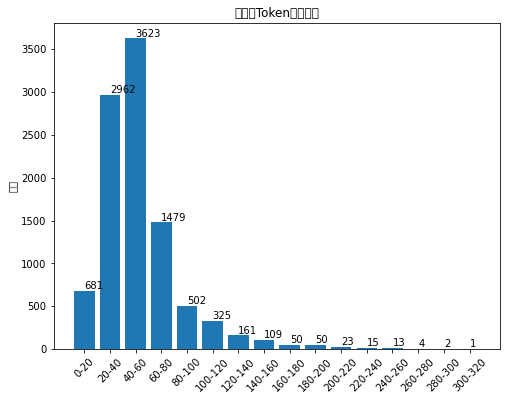

In [19]:
import json
#from tokenizer import Tokenizer
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']

def get_num_tokens(file_path, tokenizer):
    input_num_tokens = []
    with open(file_path, "r", encoding="utf-8") as r:
        for line in r:
            line = json.loads(line)
            question = line["question"]
            answer = line["answer"]
            tokens, att_mask = tokenizer.encode(question, answer)
            input_num_tokens.append(len(tokens))
    return input_num_tokens

def count_intervals(num_tokens, interval):
    max_value = max(num_tokens)
    intervals_count = {}
    for lower_bound in range(0, max_value + 1, interval):
        upper_bound = lower_bound + interval
        count = len([num for num in num_tokens if lower_bound <= num < upper_bound])
        intervals_count[f"{lower_bound}-{upper_bound}"] = count
    return intervals_count

def main():
    train_data_path = "data/train.json"
    tokenizer = Tokenizer("data/vocab.json")
    input_num_tokens = get_num_tokens(train_data_path, tokenizer)
    intervals_count = count_intervals(input_num_tokens, 20)
    print(intervals_count)
    x = [k for k, v in intervals_count.items()]
    y = [v for k, v in intervals_count.items()]
    plt.figure(figsize=(8, 6))
    bars = plt.bar(x, y)
    plt.title('Token Distribution in Training Dataset')
    plt.ylabel('Quantity')
    plt.xticks(rotation=45)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom')
    plt.show()

if __name__ == '__main__':
    main()

In [20]:
# -*- coding: utf-8 -*-
from torch.utils.data import Dataset
import torch
import json
import numpy as np


class QADataset(Dataset):
    def __init__(self, data_path, tokenizer, max_length) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        if data_path:
            with open(data_path, "r", encoding='utf-8') as f:
                for line in f:
                    if not line or line == "":
                        continue
                    json_line = json.loads(line)
                    question = json_line["question"]
                    answer = json_line["answer"]
                    self.data.append({
                        "question": question,
                        "answer": answer
                    })
        print("data load ， size：", len(self.data))

    def preprocess(self, question, answer):
        encode, att_mask = self.tokenizer.encode(question, answer, max_length=self.max_length, pad_to_max_length=True)
        input_ids = encode[:-1]
        att_mask = att_mask[:-1]
        labels = encode[1:]
        return input_ids, att_mask, labels

    def __getitem__(self, index):
        item_data = self.data[index]
        input_ids, att_mask, labels = self.preprocess(**item_data)
        return {
            "input_ids": torch.LongTensor(np.array(input_ids)),
            "attention_mask": torch.LongTensor(np.array(att_mask)),
            "labels": torch.LongTensor(np.array(labels))
        }

    def __len__(self):
        return len(self.data)

In [22]:
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
#from tokenizer import Tokenizer
#from model import GPTModel
#from qa_dataset import QADataset
from tqdm import tqdm
import time, sys, os


def train_model(model, train_loader, val_loader, optimizer, criterion,
                device, num_epochs, model_output_dir, writer):
    batch_step = 0
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        time1 = time.time()
        model.train()
        for index, data in enumerate(tqdm(train_loader, file=sys.stdout, desc="Train Epoch: " + str(epoch))):
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            labels = data['labels'].to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs, dec_self_attns = model(input_ids, attention_mask)
            loss = criterion(outputs, labels.view(-1))
            loss.backward()
            # gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            writer.add_scalar('Loss/train', loss, batch_step)
            batch_step += 1
            # print loss every 100 times
            if index % 1 == 0 or index == len(train_loader) - 1:
                time2 = time.time()
                tqdm.write(
                    f"{index}, epoch: {epoch} -loss: {str(loss)} ; lr: {optimizer.param_groups[0]['lr']} ;each step's time spent: {(str(float(time2 - time1) / float(index + 0.0001)))}")
        # validation
        model.eval()
        val_loss = validate_model(model, criterion, device, val_loader)
        writer.add_scalar('Loss/val', val_loss, epoch)
        print(f"val loss: {val_loss} , epoch: {epoch}")
        # save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(model_output_dir, "best.pt")
            print("Save Best Model To ", best_model_path, ", epoch: ", epoch)
            torch.save(model.state_dict(), best_model_path)
        # save current model
        last_model_path = os.path.join(model_output_dir, "last.pt")
        print("Save Last Model To ", last_model_path, ", epoch: ", epoch)
        torch.save(model.state_dict(), last_model_path)


def validate_model(model, criterion, device, val_loader):
    running_loss = 0.0
    with torch.no_grad():
        for _, data in enumerate(tqdm(val_loader, file=sys.stdout, desc="Validation Data")):
            input_ids = data['input_ids'].to(device, dtype=torch.long)
            attention_mask = data['attention_mask'].to(device, dtype=torch.long)
            labels = data['labels'].to(device, dtype=torch.long)
            outputs, dec_self_attns = model(input_ids, attention_mask)
            loss = criterion(outputs, labels.view(-1))
            running_loss += loss.item()
    return running_loss / len(val_loader)


def main():
    train_json_path = "data/train.json"  # Training set
    val_json_path = "data/val.json"  # Validation set
    vocab_path = "data/vocab.json"  # Vocabulary path
    max_length = 120  # maximum length
    epochs = 15 # epoch
    batch_size = 128  # each batch 128 
    lr = 1e-4  # leaerning rate
    model_output_dir = "output"  # save model to dir
    logs_dir = "logs"  # log dir
    # device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Tokenizer loading
    tokenizer = Tokenizer(vocab_path)
    # model parameter
    model_param = {
        "d_model": 768,  # embedding
        "d_ff": 2048,  # forward feed net
        "d_k": 64,  # K
        "d_v": 64,  # V
        "n_layers": 6,  # number of decoding layers
        "n_heads": 8,  # number of multi-head attention heads
        "max_pos": 1800,  # length of positional encoding
        "device": device,  # device
        "vocab_size": tokenizer.get_vocab_size(),  # vocabulary size
    }
    model = GPTModel(**model_param)
    print("Start Load Train Data...")
    train_params = {
        "batch_size": batch_size,
        "shuffle": True,
        "num_workers": 4,
    }
    training_set = QADataset(train_json_path, tokenizer, max_length)
    training_loader = DataLoader(training_set, **train_params)
    print("Start Load Validation Data...")
    val_params = {
        "batch_size": batch_size,
        "shuffle": False,
        "num_workers": 4,
    }
    val_set = QADataset(val_json_path, tokenizer, max_length)
    val_loader = DataLoader(val_set, **val_params)
    # log 
    writer = SummaryWriter(logs_dir)
    # optimizer
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
    # loss function
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0).to(device)
    model = model.to(device)
    # Start training
    print("Start Training...")
    train_model(
        model=model,
        train_loader=training_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=device,
        num_epochs=epochs,
        model_output_dir=model_output_dir,
        writer=writer
    )
    writer.close()


if __name__ == '__main__':
    main()

Start Load Train Data...
data load ， size： 10000
Start Load Validation Data...
data load ， size： 1000
Start Training...
Train Epoch: 0:   0%|          | 0/79 [09:10<?, ?it/s]


KeyboardInterrupt: 

In [24]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cpu')